In [28]:
import pandas as pd
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer

In [30]:
set_labels =['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
                 'Fibrosis','Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
                 'Pneumonia','Pneumothorax']
    
## convert to Multilabels 
mlb = MultiLabelBinarizer(classes=set_labels)
mlb.fit(set_labels)

MultiLabelBinarizer(classes=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
          sparse_output=False)

In [31]:
def label2vector(label):
    
    ## INPUT : ['Atelectasis', 'Cardiomegaly']
    ## OUTPUT : [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    label = [label]
    test_labels_str = [i.split('|') for i in label]
    test_labels_str = [ x if 'Finding' not in x[0] else [] for x in (test_labels_str)]
    return mlb.transform(test_labels_str)[0]

def get_vector_labels(path, is_test):
    
    ## INPUT : ('../data/images/, True)
    ## OUTPUT : 
    
#         img_filename	             vector
# 44187   00013774_026.png    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
# 44188   00013774_028.png    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    
    
    ## read list of non-blacklisted images; train and test 
    if not is_test:
        train_img_list = pd.read_pickle(path + "train_val_filtered.pkl")
    else:
        train_img_list = pd.read_pickle(path + "test_filtered.pkl")
        
    ## read images in our images folder 
    single_tar_images = [i.split('/')[1] for i in glob.glob(path + '*.png')]
    ## subset 
    train_img_list = train_img_list[train_img_list['img_filename'].isin(single_tar_images)]
    
    train_img_list['vector'] = train_img_list['text_label'].apply(label2vector)
    train_img_list = train_img_list[['img_filename', 'vector']]
    return train_img_list

def train_val_splitter(train_df, percentage = 0.1):
    
    assert percentage <= 1
    assert percentage > 0
    
    ## INPUT :  training_df of the shape (n,2), 0 <float <=1
    ## OUTPUT : validation_df, train_df; no patient overlap in the two dfs
                # validation_Df.shape = ~(n*percentage,2), 
                # train_df.shape = ~(n*(1-percentage), 2)
    
    col_list = train_df.columns.tolist()
    
    train_df['patient'] = train_df.img_filename.apply(lambda x : x.split("_")[0])
    valid_patients = np.random.choice(train_df.patient.unique(), 
                 int(train_df.patient.unique().shape[0]*percentage),
                 replace=False)
    
    valid_df = train_df[train_df['patient'].isin(valid_patients)]
    dummy = train_df[~train_df['patient'].isin(valid_patients)]
    
    # assert no rows are missed 
    assert valid_df.shape[0] + dummy.shape[0] == train_df.shape[0]
    # assert intersection is null
    assert np.intersect1d(valid_df.patient.values, dummy.patient.values).tolist() == []
    
    return valid_df[col_list], dummy[col_list]

In [32]:
train_df = get_vector_labels(path = 'images/', is_test = False)
test_df = get_vector_labels(path = 'images/', is_test = True)
valid_df, train_df = train_val_splitter(train_df, 0.2)
print (valid_df.shape, train_df.shape, test_df.shape)

(14250, 2) (59028, 2) (22053, 2)


In [33]:
y_train = np.vstack(train_df.vector.values)
class_dist_train = np.sum(y_train, axis = 0)

set_labels.append("No Finding")

class_dist_train = np.append(class_dist_train, np.sum(np.sum(y_train, axis = 1) == 0))

y_valid = np.vstack(valid_df.vector.values)
class_dist_valid = np.round(np.sum(y_valid, axis = 0),1)
class_dist_valid = np.append(class_dist_valid,np.sum(np.sum(y_valid, axis = 1) == 0))

class_dist_valid = np.round(class_dist_valid*100/y_valid.shape[0],1)
class_dist_train = np.round(class_dist_train*100/y_train.shape[0],1)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


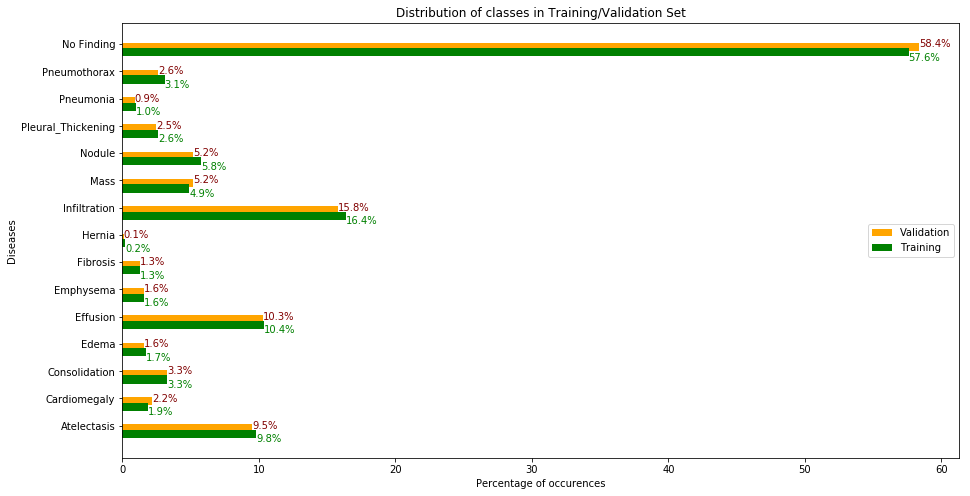

In [34]:
plt.rcParams['figure.figsize'] = [15,8]
axis_font = {'fontname':'Arial', 'size':'10'}

ind = np.arange(len(set_labels))
width = 0.3

ax = plt.subplot(111)    
ax.barh(ind + 0.2, class_dist_valid,width,  color='orange', align = 'center', label="Validation")
ax.barh(ind, class_dist_train, width, color="green", align = 'center', label="Training")
ax.set_yticklabels( set_labels)
ax.set_yticks(ind+width)
plt.title('Distribution of classes in Training/Validation Set')
plt.xlabel('Percentage of occurences')
plt.ylabel('Diseases') 
for i,v in enumerate([j for i,j in (list(zip(set_labels, class_dist_train)))]):
    ax.text(v , i - width , str(v) + '%' ,color = 'green', **axis_font)
for i,v in enumerate([j for i,j in (list(zip(set_labels, class_dist_valid)))]):    
    ax.text(v , i + width/2 + 0.05 , str(v) + '%' ,color='maroon', **axis_font)
    
plt.legend(loc = 'center right')
plt.show()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


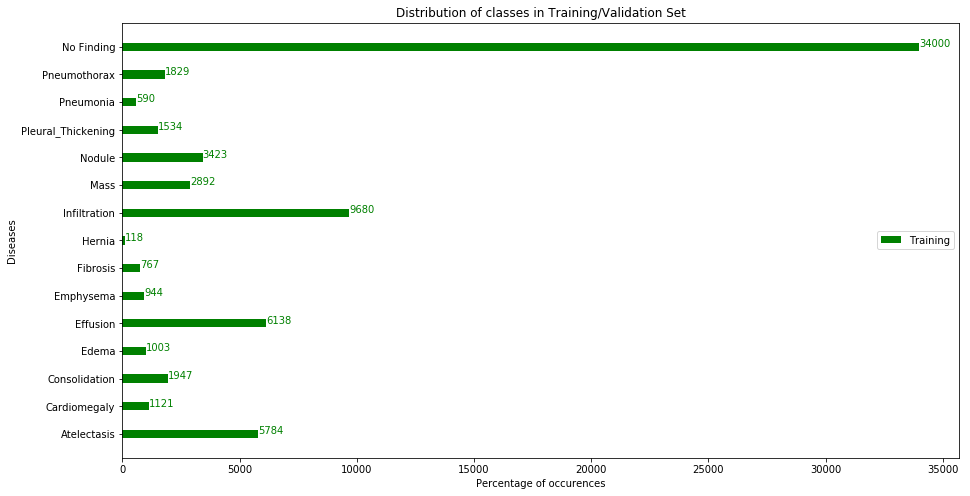

In [35]:
plt.rcParams['figure.figsize'] = [15,8]
axis_font = {'fontname':'Arial', 'size':'10'}

ind = np.arange(len(set_labels))
width = 0.3

ax = plt.subplot(111)    
# ax.barh(ind + 0.2, class_dist_valid,width,  color='orange', align = 'center', label="Validation")
ax.barh(ind, np.round(class_dist_train*y_train.shape[0]/100), width, color="green", align = 'center', label="Training")
ax.set_yticklabels( set_labels)
ax.set_yticks(ind)
plt.title('Distribution of classes in Training/Validation Set')
plt.xlabel('Percentage of occurences')
plt.ylabel('Diseases') 
for i,v in enumerate([j for i,j in (list(zip(set_labels, np.floor(class_dist_train*y_train.shape[0]/100).astype(int))))]):
    ax.text(v , i , str(v) ,color = 'green', **axis_font)
# for i,v in enumerate([j for i,j in (list(zip(set_labels, class_dist_valid)))]):    
#     ax.text(v , i + width/2 + 0.05 , str(v) ,color='maroon', **axis_font)
    
plt.legend(loc = 'center right')
plt.show()

In [36]:
# train_df = train_df.sample(10000)

In [37]:
all_results = {}
epoch_result = {}

In [38]:
CLASSES = 14
WIDTH = 224
HEIGHT = 224
LR = 0.0001
EPOCHS = 75 #100
# Can scale to max for inference but for training LR will be affected
# Prob better to increase this though on P100 since LR is not too low
# Easier to see when plotted
BATCHSIZE = 32 #64*2
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_SD = [0.229, 0.224, 0.225]

In [39]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import os
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.metrics.ranking import roc_auc_score

In [40]:
assert torch.cuda.is_available()
torch.cuda.get_device_capability(torch.cuda.current_device())

(7, 0)

In [41]:
class XRayDataset(Dataset):

    def __init__(self, train_df, root_dir, transform=None):
        self.df = train_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = torch.FloatTensor(self.df[self.df['img_filename'] == self.df.iloc[idx, 0]]['vector'].values[0])
        #labels = torch.FloatTensor(np.array([0]*14))

        if self.transform is not None:
            image = self.transform(image)

        return image, labels

In [42]:
# WIDTH = 224
# IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_RGB_SD = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_SD)

train_dataset = XRayDataset(train_df,
                                    root_dir= os.path.join(os.getcwd() + '/images/'), 
                           transform=transforms.Compose([
                           transforms.Resize(WIDTH),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomResizedCrop(size=WIDTH),
                            transforms.ColorJitter(0.15, 0.15),
                            transforms.RandomRotation(15),
                           transforms.ToTensor(),
                           normalize]))

test_dataset = XRayDataset(test_df,
                                    root_dir= os.path.join(os.getcwd() + '/images/'), 
                           transform=transforms.Compose([
                           transforms.Resize(WIDTH),
                           transforms.ToTensor(),
                           normalize]))

valid_dataset = XRayDataset(valid_df,
                                    root_dir= os.path.join(os.getcwd() + '/images/'), 
                           transform=transforms.Compose([
                           transforms.Resize(WIDTH),
                           transforms.ToTensor(),
                           normalize]))

In [43]:
def get_symbol(out_features=CLASSES):
    model = models.densenet.densenet121(pretrained=True)
    # Replace classifier (FC-1000) with (FC-14)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, out_features), 
        nn.Sigmoid())
    # CUDA
    model.cuda()  
    return model

# model = models.densenet.densenet121(pretrained=True)

# model.classifier = nn.Sequential(
#         nn.Linear(model.classifier.in_features, 14),
#         nn.Sigmoid())
# model.cuda()


def init_symbol(sym, lr=LR):
    # torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    opt = optim.Adam(sym.parameters(), lr=lr, betas=(0.9, 0.999))
    criterion = nn.BCELoss()
    scheduler = ReduceLROnPlateau(opt, factor = 0.1, patience = 5, mode = 'min')
    return opt, criterion, scheduler

# optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
# criterion = nn.BCELoss()
# scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')

In [56]:
def compute_roc_auc(data_gt, data_pd, mean=False, classes=CLASSES):
    roc_auc = []
    data_gt = data_gt.cpu().numpy()
    data_pd = data_pd.cpu().numpy()
    for i in range(classes):
        roc_auc.append(roc_auc_score(data_gt[:, i], data_pd[:, i]))
        roc_auc = list(np.round(np.array(roc_auc),4))
    if mean:
        roc_auc = np.mean(roc_auc)
    return roc_auc

In [45]:
def train_epoch(model, dataloader, optimizer, criterion, epoch, batch=BATCHSIZE):
    model.train()
    print("Training epoch {}".format(epoch+1))
    loss_val = 0
    loss_cnt = 0
    for data, target in tqdm(dataloader):
        # Get samples
        data = Variable(torch.FloatTensor(data).cuda())
        target = Variable(torch.FloatTensor(target).cuda())
        # Init
        optimizer.zero_grad()
        # Forwards
        output = model(data)
        # Loss
        loss = criterion(output, target)
        # Back-prop
        loss.backward()
        optimizer.step()   
         # Log the loss
        loss_val += loss.data[0]
        loss_cnt += 1
    print("Training loss: {0:.4f}".format(loss_val/loss_cnt))


def valid_epoch(model, dataloader, criterion, epoch, phase='valid', batch=BATCHSIZE):
    model.eval()
    if phase == 'testing':
        print("Testing epoch {}".format(epoch+1))
    else:
        print("Validating epoch {}".format(epoch+1))
    out_pred = torch.FloatTensor().cuda()
    out_gt = torch.FloatTensor().cuda()
    loss_val = 0
    loss_cnt = 0
    for data, target in dataloader:
        # Get samples
        data = Variable(torch.FloatTensor(data).cuda(), volatile=True)
        target = Variable(torch.FloatTensor(target).cuda(), volatile=True)
         # Forwards
        output = model(data)
        # Loss
        loss = criterion(output, target)
        # Log the loss
        loss_val += loss.data[0]
        loss_cnt += 1
        # Log for AUC
        out_pred = torch.cat((out_pred, output.data), 0)
        out_gt = torch.cat((out_gt, target.data), 0)
    loss_mean = loss_val/loss_cnt
    if phase == 'testing':
        print("Test-Dataset loss: {0:.4f}".format(loss_mean))
        print("Test-Dataset AUC: {}".format(compute_roc_auc(out_gt, out_pred)))
        print("Test-Dataset AUC: {0:.4f}".format(np.mean(compute_roc_auc(out_gt, out_pred))))
    else:
        print("Validation loss: {0:.4f}".format(loss_mean))
        print("Validation AUC: {}".format(compute_roc_auc(out_gt, out_pred)))
        print("Validation AUC: {0:.4f}".format(np.mean(compute_roc_auc(out_gt, out_pred))))
#         print("Validation AUC: {0:.4f}".format(compute_roc_auc(out_gt, out_pred)))
#     epoch_result['AUC'] = np.mean(compute_roc_auc(out_gt, out_pred))
#     epoch_result['AUC_list'] = compute_roc_auc(out_gt, out_pred)
    all_results[epoch + 1] = (np.mean(compute_roc_auc(out_gt, out_pred)),  
                              compute_roc_auc(out_gt, out_pred))
    return loss_mean

def print_learning_rate(opt):
    for param_group in opt.param_groups:
        print("Learining rate: ", param_group['lr'])

In [46]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCHSIZE,
                          shuffle=True, num_workers=24, pin_memory=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=8*BATCHSIZE,
                          shuffle=False, num_workers=8, pin_memory=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=8*BATCHSIZE,
                         shuffle=False, num_workers=8, pin_memory=False)

In [47]:
%%time
# Load symbol
azure_chest_xray_sym = get_symbol()

CPU times: user 104 ms, sys: 48 ms, total: 152 ms
Wall time: 152 ms


In [48]:
%%time
# Load optimiser, loss
optimizer, criterion, scheduler = init_symbol(azure_chest_xray_sym)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.22 ms


In [49]:
loss_min = float("inf")    
stime = time.time()

# No-training
valid_epoch(azure_chest_xray_sym, valid_loader, criterion, -1)

# Main train/val/test loop
for j in (range(EPOCHS)):
    train_epoch(azure_chest_xray_sym, train_loader, optimizer, criterion, j)
    loss_val = valid_epoch(azure_chest_xray_sym, valid_loader, criterion, j)
#     print (all_results)
#     test_loss_val = valid_epoch(azure_chest_xray_sym, test_loader, criterion, j, 'testing')
    # LR Schedule
    scheduler.step(loss_val)
    print_learning_rate(optimizer)
    # todo: tensorboard hooks
    # Logging
    if loss_val < loss_min:
        print("Loss decreased. Saving ...")
        loss_min = loss_val
        torch.save({'epoch': j + 1, 
                    'state_dict': azure_chest_xray_sym.state_dict(), 
                    'best_loss': loss_min, 
                    'optimizer' : optimizer.state_dict()}, 'best_azure_chest_xray_model_v2.pth.tar')
    etime = time.time()
    print("Epoch time: {0:.0f} seconds".format(etime-stime))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Validating epoch 0
Validation loss: 0.6695
Validation AUC: [0.51, 0.47, 0.63, 0.47, 0.58, 0.36, 0.5, 0.46, 0.55, 0.49, 0.5, 0.52, 0.45, 0.48]
Validation AUC: 0.4979



  0%|          | 0/1845 [00:00<?, ?it/s]

Training epoch 1



100%|██████████| 1845/1845 [06:16<00:00,  4.90it/s]

Training loss: 0.1603
Validating epoch 1


Validation loss: 0.1430
Validation AUC: [0.79, 0.82, 0.8, 0.88, 0.87, 0.78, 0.71, 0.69, 0.67, 0.76, 0.69, 0.77, 0.7, 0.75]
Validation AUC: 0.7629
Learining rate:  0.0001
Loss decreased. Saving ...


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 550 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 2


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1473
Validating epoch 2


Validation loss: 0.1373
Validation AUC: [0.8, 0.87, 0.8, 0.9, 0.89, 0.84, 0.75, 0.72, 0.68, 0.79, 0.73, 0.77, 0.73, 0.79]
Validation AUC: 0.7900
Learining rate:  0.0001
Loss decreased. Saving ...


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 989 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 3


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1447
Validating epoch 3


Validation loss: 0.1369
Validation AUC: [0.81, 0.88, 0.81, 0.89, 0.89, 0.86, 0.74, 0.77, 0.68, 0.8, 0.72, 0.78, 0.74, 0.8]
Validation AUC: 0.7979
Learining rate:  0.0001
Loss decreased. Saving ...


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 1429 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 4


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1430
Validating epoch 4


Validation loss: 0.1358
Validation AUC: [0.81, 0.88, 0.81, 0.9, 0.89, 0.88, 0.76, 0.82, 0.69, 0.82, 0.72, 0.79, 0.73, 0.81]
Validation AUC: 0.8079
Learining rate:  0.0001
Loss decreased. Saving ...


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 1868 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 5


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1418
Validating epoch 5


Validation loss: 0.1368
Validation AUC: [0.8, 0.89, 0.81, 0.91, 0.89, 0.89, 0.75, 0.81, 0.69, 0.82, 0.74, 0.78, 0.75, 0.83]
Validation AUC: 0.8114


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 2307 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 6


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1406
Validating epoch 6


Validation loss: 0.1377
Validation AUC: [0.79, 0.89, 0.8, 0.91, 0.89, 0.88, 0.75, 0.81, 0.67, 0.81, 0.74, 0.77, 0.72, 0.82]
Validation AUC: 0.8036


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 2745 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 7


100%|██████████| 1845/1845 [06:11<00:00,  4.96it/s]

Training loss: 0.1396
Validating epoch 7


Validation loss: 0.1376
Validation AUC: [0.8, 0.87, 0.81, 0.9, 0.89, 0.88, 0.75, 0.83, 0.69, 0.84, 0.75, 0.77, 0.75, 0.82]
Validation AUC: 0.8107


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 3184 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 8


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1390
Validating epoch 8


Validation loss: 0.1346
Validation AUC: [0.82, 0.88, 0.81, 0.91, 0.89, 0.9, 0.76, 0.81, 0.68, 0.83, 0.75, 0.78, 0.71, 0.82]
Validation AUC: 0.8107
Learining rate:  0.0001
Loss decreased. Saving ...


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 3623 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 9


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1380
Validating epoch 9


Validation loss: 0.1343
Validation AUC: [0.82, 0.88, 0.81, 0.9, 0.89, 0.89, 0.76, 0.8, 0.69, 0.83, 0.75, 0.78, 0.74, 0.83]
Validation AUC: 0.8121
Learining rate:  0.0001
Loss decreased. Saving ...


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 4062 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 10


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1371
Validating epoch 10


Validation loss: 0.1340
Validation AUC: [0.81, 0.89, 0.81, 0.89, 0.89, 0.89, 0.75, 0.84, 0.69, 0.83, 0.76, 0.79, 0.72, 0.82]
Validation AUC: 0.8129
Learining rate:  0.0001
Loss decreased. Saving ...


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 4501 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 11


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1367
Validating epoch 11


Validation loss: 0.1342
Validation AUC: [0.82, 0.89, 0.81, 0.91, 0.9, 0.9, 0.76, 0.82, 0.69, 0.83, 0.75, 0.78, 0.75, 0.83]
Validation AUC: 0.8171


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 4940 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 12


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1358
Validating epoch 12


Validation loss: 0.1342
Validation AUC: [0.82, 0.89, 0.81, 0.89, 0.89, 0.89, 0.75, 0.86, 0.69, 0.84, 0.76, 0.78, 0.72, 0.83]
Validation AUC: 0.8157


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 5378 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 13


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1352
Validating epoch 13


Validation loss: 0.1334
Validation AUC: [0.82, 0.89, 0.81, 0.89, 0.9, 0.9, 0.75, 0.83, 0.68, 0.83, 0.74, 0.76, 0.74, 0.83]
Validation AUC: 0.8121
Learining rate:  0.0001
Loss decreased. Saving ...


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 5817 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 14


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1347
Validating epoch 14


Validation loss: 0.1339
Validation AUC: [0.82, 0.89, 0.82, 0.91, 0.9, 0.9, 0.75, 0.85, 0.69, 0.83, 0.76, 0.78, 0.75, 0.83]
Validation AUC: 0.8200
Learining rate:  0.0001


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 6255 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 15


100%|██████████| 1845/1845 [06:11<00:00,  4.96it/s]

Training loss: 0.1344
Validating epoch 15


Validation loss: 0.1345
Validation AUC: [0.82, 0.88, 0.81, 0.9, 0.9, 0.89, 0.76, 0.84, 0.69, 0.84, 0.76, 0.78, 0.74, 0.83]
Validation AUC: 0.8171


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 6694 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 16


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]


Training loss: 0.1333
Validating epoch 16
Validation loss: 0.1330
Validation AUC: [0.83, 0.88, 0.81, 0.91, 0.9, 0.89, 0.75, 0.84, 0.69, 0.84, 0.76, 0.78, 0.75, 0.83]
Validation AUC: 0.8186
Learining rate:  0.0001
Loss decreased. Saving ...


  0%|          | 0/1845 [00:00<?, ?it/s]

Epoch time: 7133 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 17


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1326
Validating epoch 17


Validation loss: 0.1381
Validation AUC: [0.82, 0.89, 0.8, 0.9, 0.9, 0.89, 0.75, 0.83, 0.68, 0.83, 0.75, 0.78, 0.75, 0.82]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 7571 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 18


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1321
Validating epoch 18


Validation loss: 0.1341
Validation AUC: [0.82, 0.88, 0.81, 0.9, 0.9, 0.9, 0.76, 0.84, 0.69, 0.84, 0.75, 0.78, 0.75, 0.84]
Validation AUC: 0.8186


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 8010 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 19


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1314
Validating epoch 19


Validation loss: 0.1351
Validation AUC: [0.83, 0.89, 0.81, 0.9, 0.9, 0.9, 0.74, 0.82, 0.69, 0.84, 0.75, 0.78, 0.74, 0.83]
Validation AUC: 0.8157


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 8448 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 20


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1308
Validating epoch 20


Validation loss: 0.1349
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.76, 0.79, 0.69, 0.83, 0.77, 0.78, 0.72, 0.83]
Validation AUC: 0.8107


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 8887 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 21


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1303
Validating epoch 21


Validation loss: 0.1361
Validation AUC: [0.82, 0.87, 0.8, 0.91, 0.89, 0.9, 0.74, 0.81, 0.68, 0.83, 0.77, 0.76, 0.74, 0.82]
Validation AUC: 0.8100


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  0.0001
Epoch time: 9325 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 22


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1294
Validating epoch 22


Validation loss: 0.1381
Validation AUC: [0.82, 0.88, 0.8, 0.89, 0.89, 0.89, 0.73, 0.82, 0.68, 0.83, 0.76, 0.75, 0.72, 0.82]
Validation AUC: 0.8057


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1e-05
Epoch time: 9764 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 23


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1251
Validating epoch 23


Validation loss: 0.1347
Validation AUC: [0.82, 0.89, 0.8, 0.9, 0.89, 0.9, 0.74, 0.82, 0.69, 0.84, 0.77, 0.78, 0.74, 0.83]
Validation AUC: 0.8150


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1e-05
Epoch time: 10203 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 24


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1237
Validating epoch 24


Validation loss: 0.1353
Validation AUC: [0.82, 0.89, 0.8, 0.9, 0.89, 0.9, 0.74, 0.81, 0.69, 0.85, 0.77, 0.77, 0.74, 0.84]
Validation AUC: 0.8150


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1e-05
Epoch time: 10641 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 25


100%|██████████| 1845/1845 [06:13<00:00,  4.95it/s]

Training loss: 0.1228
Validating epoch 25


Validation loss: 0.1359
Validation AUC: [0.82, 0.89, 0.79, 0.9, 0.89, 0.9, 0.74, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8150


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1e-05
Epoch time: 11082 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 26


100%|██████████| 1845/1845 [06:14<00:00,  4.93it/s]

Training loss: 0.1222
Validating epoch 26


Validation loss: 0.1359
Validation AUC: [0.82, 0.89, 0.8, 0.9, 0.89, 0.9, 0.73, 0.81, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8143


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1e-05
Epoch time: 11522 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 27


100%|██████████| 1845/1845 [06:14<00:00,  4.93it/s]

Training loss: 0.1217
Validating epoch 27


Validation loss: 0.1366
Validation AUC: [0.82, 0.89, 0.79, 0.9, 0.89, 0.9, 0.73, 0.81, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1e-05
Epoch time: 11964 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 28


100%|██████████| 1845/1845 [06:14<00:00,  4.93it/s]

Training loss: 0.1212
Validating epoch 28


Validation loss: 0.1370
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-06
Epoch time: 12404 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 29


100%|██████████| 1845/1845 [06:14<00:00,  4.93it/s]

Training loss: 0.1203
Validating epoch 29


Validation loss: 0.1366
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.81, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8121


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-06
Epoch time: 12845 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 30


100%|██████████| 1845/1845 [06:14<00:00,  4.93it/s]

Training loss: 0.1201
Validating epoch 30


Validation loss: 0.1373
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.84, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8121


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-06
Epoch time: 13286 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 31


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1202
Validating epoch 31


Validation loss: 0.1375
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-06
Epoch time: 13725 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 32


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 32


Validation loss: 0.1379
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-06
Epoch time: 14165 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 33


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 33


Validation loss: 0.1374
Validation AUC: [0.82, 0.88, 0.79, 0.89, 0.89, 0.9, 0.73, 0.82, 0.69, 0.84, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8114


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-06
Epoch time: 14603 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 34


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1200
Validating epoch 34


Validation loss: 0.1376
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8143


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-07
Epoch time: 15042 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 35


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1199
Validating epoch 35


Validation loss: 0.1376
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-07
Epoch time: 15481 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 36


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1201
Validating epoch 36


Validation loss: 0.1377
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-07
Epoch time: 15920 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 37


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1200
Validating epoch 37


Validation loss: 0.1371
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.81, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8121


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-07
Epoch time: 16358 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 38


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1198
Validating epoch 38


Validation loss: 0.1374
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-07
Epoch time: 16797 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 39


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1202
Validating epoch 39


Validation loss: 0.1371
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.84]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000002e-07
Epoch time: 17236 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 40


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1195
Validating epoch 40


Validation loss: 0.1372
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 17675 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 41


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1198
Validating epoch 41


Validation loss: 0.1381
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 18113 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 42


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1198
Validating epoch 42


Validation loss: 0.1373
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 18552 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 43


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 43


Validation loss: 0.1371
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8143


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 18991 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 44


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1200
Validating epoch 44


Validation loss: 0.1381
Validation AUC: [0.82, 0.88, 0.79, 0.89, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8121


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 19429 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 45


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 45


Validation loss: 0.1375
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 19867 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 46


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1202
Validating epoch 46


Validation loss: 0.1374
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 20306 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 47


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1201
Validating epoch 47


Validation loss: 0.1369
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.84]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 20745 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 48


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1198
Validating epoch 48


Validation loss: 0.1374
Validation AUC: [0.82, 0.88, 0.79, 0.89, 0.89, 0.9, 0.73, 0.82, 0.69, 0.84, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8114


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 21184 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 49


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 49


Validation loss: 0.1381
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 21623 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 50


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1194
Validating epoch 50


Validation loss: 0.1377
Validation AUC: [0.82, 0.88, 0.79, 0.89, 0.89, 0.9, 0.73, 0.82, 0.69, 0.84, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8114


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 22062 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 51


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 51


Validation loss: 0.1372
Validation AUC: [0.82, 0.88, 0.79, 0.89, 0.89, 0.9, 0.73, 0.81, 0.69, 0.84, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8107


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 22500 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 52


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 52


Validation loss: 0.1378
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 22939 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 53


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1198
Validating epoch 53


Validation loss: 0.1374
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8143


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 23378 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 54


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1200
Validating epoch 54


Validation loss: 0.1371
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.81, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 23816 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 55


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1197
Validating epoch 55


Validation loss: 0.1376
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8143


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 24255 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 56


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1202
Validating epoch 56


Validation loss: 0.1371
Validation AUC: [0.82, 0.88, 0.79, 0.89, 0.89, 0.9, 0.73, 0.82, 0.69, 0.84, 0.77, 0.76, 0.74, 0.84]
Validation AUC: 0.8114


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 24694 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 57


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1201
Validating epoch 57


Validation loss: 0.1376
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.84]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 25133 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 58


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1201
Validating epoch 58


Validation loss: 0.1376
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 25572 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 59


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1198
Validating epoch 59


Validation loss: 0.1376
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 26010 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 60


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1199
Validating epoch 60


Validation loss: 0.1372
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8143


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 26449 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 61


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1201
Validating epoch 61


Validation loss: 0.1371
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.84]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 26888 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 62


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1197
Validating epoch 62


Validation loss: 0.1376
Validation AUC: [0.82, 0.88, 0.79, 0.89, 0.89, 0.9, 0.73, 0.82, 0.69, 0.84, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8114


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 27326 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 63


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]


Training loss: 0.1198
Validating epoch 63
Validation loss: 0.1375
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.81, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 27764 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 64


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1202
Validating epoch 64


Validation loss: 0.1373
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 28203 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 65


100%|██████████| 1845/1845 [06:11<00:00,  4.96it/s]

Training loss: 0.1198
Validating epoch 65


Validation loss: 0.1375
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 28642 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 66


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1202
Validating epoch 66


Validation loss: 0.1371
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.81, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8121


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 29080 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 67


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 67


Validation loss: 0.1376
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8143


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 29519 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 68


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1200
Validating epoch 68


Validation loss: 0.1378
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.74, 0.83]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 29957 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 69


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 69


Validation loss: 0.1376
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8143


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 30396 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 70


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1197
Validating epoch 70


Validation loss: 0.1370
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.81, 0.69, 0.85, 0.77, 0.77, 0.74, 0.84]
Validation AUC: 0.8129


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 30834 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 71


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1203
Validating epoch 71


Validation loss: 0.1379
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 31273 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 72


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1202
Validating epoch 72


Validation loss: 0.1375
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.81, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 31712 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 73


100%|██████████| 1845/1845 [06:12<00:00,  4.95it/s]

Training loss: 0.1197
Validating epoch 73


Validation loss: 0.1379
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.84]
Validation AUC: 0.8143


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 32151 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 74


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 74


Validation loss: 0.1374
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136


  0%|          | 0/1845 [00:00<?, ?it/s]

Learining rate:  1.0000000000000004e-08
Epoch time: 32589 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training epoch 75


100%|██████████| 1845/1845 [06:12<00:00,  4.96it/s]

Training loss: 0.1199
Validating epoch 75


Validation loss: 0.1375
Validation AUC: [0.82, 0.88, 0.79, 0.9, 0.89, 0.9, 0.73, 0.82, 0.69, 0.85, 0.77, 0.77, 0.75, 0.83]
Validation AUC: 0.8136
Learining rate:  1.0000000000000004e-08
Epoch time: 33027 seconds
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [50]:
# Load model for testing
azure_chest_xray_sym_test = get_symbol()
chkpt = torch.load("best_azure_chest_xray_model_v2.pth.tar")
azure_chest_xray_sym_test.load_state_dict(chkpt['state_dict'])

In [57]:
valid_loss = valid_epoch(azure_chest_xray_sym_test, valid_loader, criterion, -1)
test_loss = valid_epoch(azure_chest_xray_sym_test, test_loader, criterion, -1, 'testing')

Validating epoch 0
Validation loss: 0.1330
Validation AUC: [0.8264, 0.885, 0.8131, 0.906, 0.8972, 0.8916, 0.7534, 0.8353, 0.6931, 0.8412, 0.7629, 0.7823, 0.7523, 0.833]
Validation AUC: 0.8195
Testing epoch 0
Test-Dataset loss: 0.1984
Test-Dataset AUC: [0.7684, 0.8561, 0.7565, 0.8435, 0.8242, 0.8705, 0.8097, 0.8982, 0.7069, 0.821, 0.7574, 0.7688, 0.7251, 0.8331]
Test-Dataset AUC: 0.8028


In [58]:
# print (all_results)

In [59]:
import pickle

In [60]:
with open('training_results.pickle', 'wb') as handle:
    pickle.dump(all_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
with open('training_results.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [67]:
x = b.keys()

In [68]:
y = [a for a,b in b.values()]

Text(0.5,1,'Validation AUC Vs Epochs')

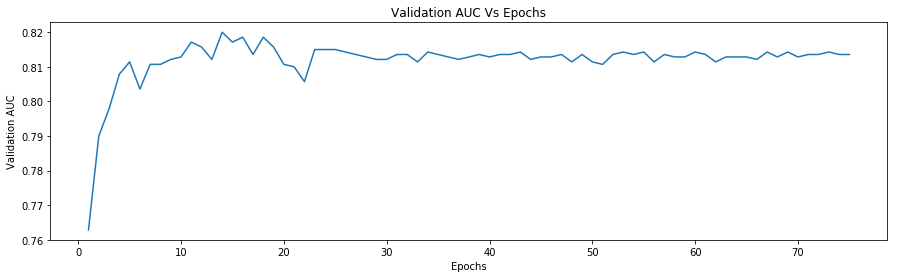

In [81]:
plt.rcParams['figure.figsize'] = [15,4]
plt.plot(list(x)[1:],y[1:])
plt.xlabel("Epochs")
plt.ylabel("Validation AUC")
plt.title("Validation AUC Vs Epochs")